In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.regularizers import l2

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

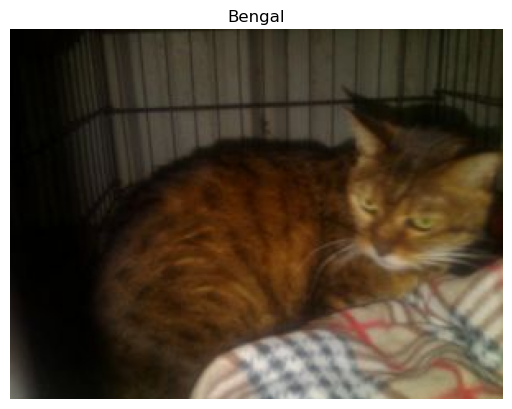

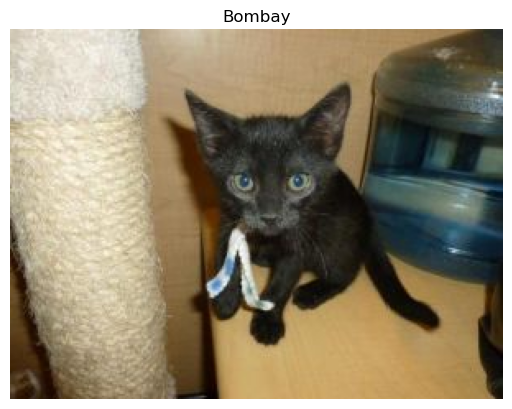

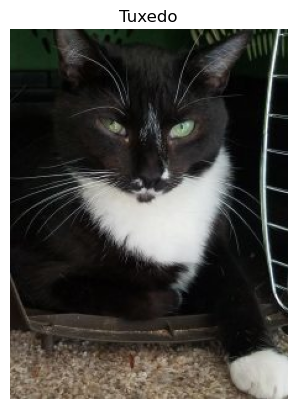

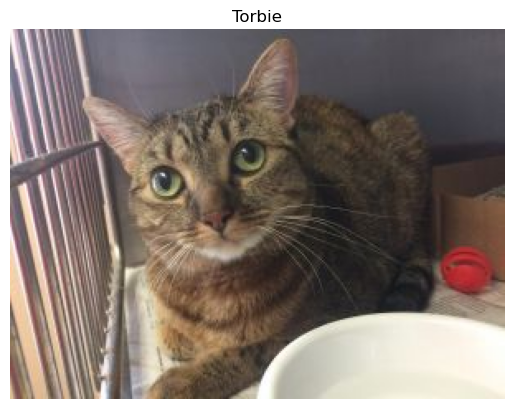

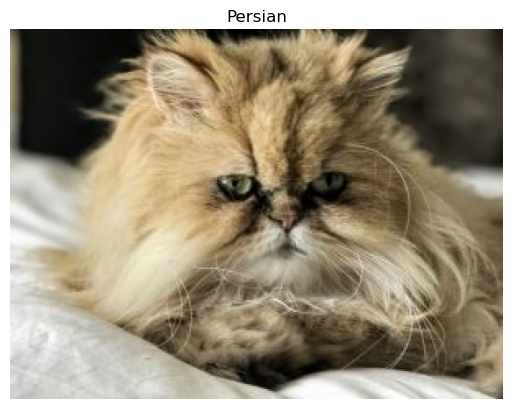

In [2]:
data_dir = '/kaggle/input/newcatbreed/CapstoneSet'  # Directory Folder

# list folder in directory
folders = os.listdir(data_dir)

# Iterate each folder
for folder in folders:
    folder_path = os.path.join(data_dir, folder)  #path curent folder
    images = os.listdir(folder_path)  # Get list image in folder
    
    if len(images) > 0:
        # Get path of first image
        image_path = os.path.join(folder_path, images[0])
        
        # Display the image
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.title(folder)  # display folder name as title
        plt.axis('off')  # Hide the axis
        plt.show()

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set dataset path
data_dir = '/kaggle/input/newcatbreed/CapstoneSet'

# training parameter
batch_size = 32
image_size = (224, 224)
input_shape = (224, 224, 3)
num_classes = 5
epochs = 100


In [4]:
# Preprocess and augment the data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [5]:
# Load and split the data into training and validation sets
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 7200 images belonging to 5 classes.


In [6]:
valid_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 1800 images belonging to 5 classes.


In [7]:
# Define the callbacks
checkpoint = ModelCheckpoint('/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [9]:
num_classes = 5
# Load the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Set the number of layers to fine-tune
fine_tune_layers = 70 # Number of top layers to unfreeze and train

# Freeze the layers up to the last fine-tune layers
for layer in base_model.layers[:-fine_tune_layers]:
    layer.trainable = False

# Create a new model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)  # Set the learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8

In [13]:
# Print the details of the data generators
print("Training Generator:")
print("Number of samples:", train_generator.samples)
print("Number of classes:", train_generator.num_classes)
print("Class labels:", train_generator.class_indices)
print()

print("Validation Generator:")
print("Number of samples:", valid_generator.samples)
print("Number of classes:", valid_generator.num_classes)
print("Class labels:", valid_generator.class_indices)

Training Generator:
Number of samples: 7200
Number of classes: 5
Class labels: {'Bengal': 0, 'Bombay': 1, 'Persian': 2, 'Torbie': 3, 'Tuxedo': 4}

Validation Generator:
Number of samples: 1800
Number of classes: 5
Class labels: {'Bengal': 0, 'Bombay': 1, 'Persian': 2, 'Torbie': 3, 'Tuxedo': 4}


In [14]:
# Train the model with fine-tuning
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    callbacks=[checkpoint,early_stopping]
)


Epoch 1/100
225/225 [==============================] - 176s 688ms/step - loss: 2.4547 - accuracy: 0.4431 - val_loss: 1.4487 - val_accuracy: 0.6981
Epoch 2/100
225/225 [==============================] - 120s 534ms/step - loss: 1.3450 - accuracy: 0.6767 - val_loss: 0.9542 - val_accuracy: 0.7952
Epoch 3/100
225/225 [==============================] - 138s 614ms/step - loss: 1.0018 - accuracy: 0.7656 - val_loss: 0.8746 - val_accuracy: 0.8337
Epoch 4/100
225/225 [==============================] - 139s 616ms/step - loss: 0.8315 - accuracy: 0.8140 - val_loss: 0.6894 - val_accuracy: 0.8477
Epoch 5/100
225/225 [==============================] - 137s 611ms/step - loss: 0.7306 - accuracy: 0.8344 - val_loss: 0.6471 - val_accuracy: 0.8655
Epoch 6/100
225/225 [==============================] - 137s 610ms/step - loss: 0.6556 - accuracy: 0.8492 - val_loss: 0.6441 - val_accuracy: 0.8594
Epoch 7/100
225/225 [==============================] - 139s 619ms/step - loss: 0.5922 - accuracy: 0.8642 - val_loss: 0

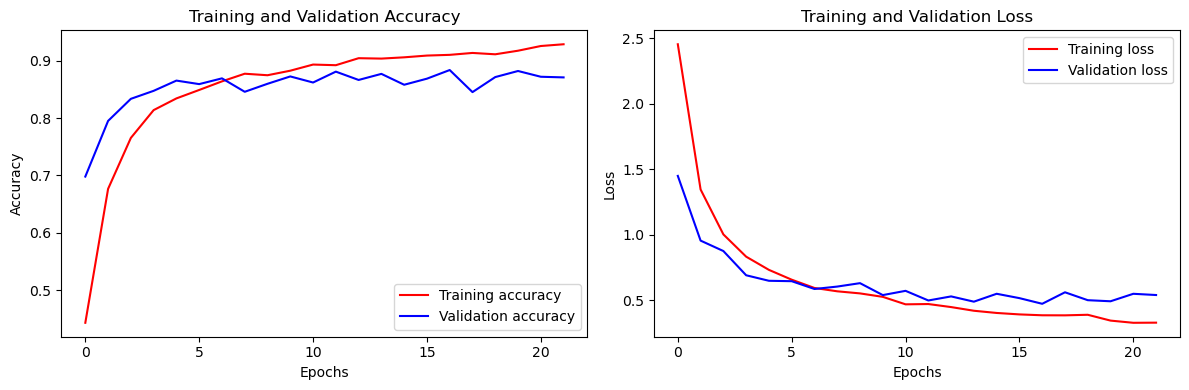

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
import json
from keras.models import model_from_json

# Save the model architecture as JSON
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

# Save the model weights in HDF5 format
model.save_weights('model_weights.h5')
